# Model Implementation, and Optimization
## Find out correct Hypothesis space (Model Space), given the training set


- Aim towards minimizing the true error on the test set.
- Avoid Overfitting the data on the training set

### Imports
We will use the standard data science and machine learning libraries in this project.

In [2]:
#Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

#No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

#Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

#Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)


#Imputing missing values and scaling values
from sklearn.preprocessing import Imputer, MinMaxScaler


#Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
#from xgboost import XGBRegressor


# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

### Read in the data, both Train and test

In [16]:
# Read in data into dataframes 
train_features = pd.read_csv('data/training_features_proc.csv')
test_features = pd.read_csv('data/testing_features_proc.csv')
train_labels = pd.read_csv('data/training_labels_proc.csv', names= ['score'])
test_labels = pd.read_csv('data/testing_labels_proc.csv' , names= ['score'])

# Display sizes of data
print('Training Feature Size: ', train_features.shape)
print('Testing Feature Size:  ', test_features.shape)
print('Training Labels Size:  ', train_labels.shape)
print('Testing Labels Size:   ', test_labels.shape)


Training Feature Size:  (69496, 49)
Testing Feature Size:   (29784, 49)
Training Labels Size:   (69496, 1)
Testing Labels Size:    (29784, 1)


In [17]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69496 entries, 0 to 69495
Data columns (total 49 columns):
CurrentLoanAmount                 69496 non-null int64
Annual Income                     69496 non-null float64
Monthly Debt                      69496 non-null float64
Years of Credit History           69496 non-null float64
Number of Open Accounts           69496 non-null int64
Number of Credit Problems         69496 non-null int64
Current Credit Balance            69496 non-null int64
Maximum Open Credit               69496 non-null float64
Bankruptcies                      69496 non-null float64
Tax Liens                         69496 non-null float64
log_Current Credit Balance        69496 non-null float64
sqrt_Maximum Open Credit          69496 non-null float64
log_Maximum Open Credit           69496 non-null float64
LoanStatus_Charged Off            69496 non-null int64
LoanStatus_Fully Paid             69496 non-null int64
Term_Long Term                    69496 non-null

In [18]:

train_features = train_features.drop(columns = "Credit Score" ) 
test_features = test_features.drop(columns = "Credit Score" ) 
cols = train_features.columns

In [19]:
cols

Index(['CurrentLoanAmount', 'Annual Income', 'Monthly Debt',
       'Years of Credit History', 'Number of Open Accounts',
       'Number of Credit Problems', 'Current Credit Balance',
       'Maximum Open Credit', 'Bankruptcies', 'Tax Liens',
       'log_Current Credit Balance', 'sqrt_Maximum Open Credit',
       'log_Maximum Open Credit', 'LoanStatus_Charged Off',
       'LoanStatus_Fully Paid', 'Term_Long Term', 'Term_Short Term',
       'Years in current job_1 year', 'Years in current job_10+ years',
       'Years in current job_2 years', 'Years in current job_3 years',
       'Years in current job_4 years', 'Years in current job_5 years',
       'Years in current job_6 years', 'Years in current job_7 years',
       'Years in current job_8 years', 'Years in current job_9 years',
       'Years in current job_< 1 year', 'Home Ownership_HaveMortgage',
       'Home Ownership_Home Mortgage', 'Home Ownership_Own Home',
       'Home Ownership_Rent', 'Purpose_Business Loan', 'Purpose_Buy Ho

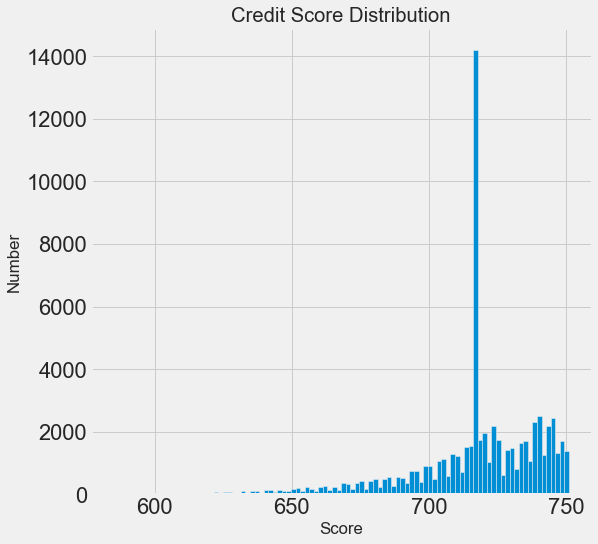

In [6]:
figsize(8, 8)

# Histogram of the Credit Score
plt.style.use('fivethirtyeight')
plt.hist(train_labels['score'].dropna(), bins = 100);
plt.xlabel('Score'); plt.ylabel('Number'); 
plt.title('Credit Score Distribution');

## Evaluating and Comparing Machine Learning Models

Build & train, and evalute several machine learning methods for our supervised regression task. The objective is to determine which model holds the most promise for further development (such as hyperparameter tuning).

We are comparing models using the mean absolute error. A baseline model that guessed the median value of the score was off by an average of 25 points.

- ### Scaling Features

This is necessary because features are in different units, and we want to normalize the features so the units do not affect the algorithm. Linear Regression and Random Forest do not require feature scaling, but other methods, such as support vector machines and k nearest neighbors, do require it because they take into account the Euclidean distance between observations. For this reason, it is a best practice to scale features when we are comparing multiple algorithms.

There are two ways to scale features:

- For each value, subtract the mean of the feature and divide by the standard deviation of the feature. This is known as standardization and results in each feature having a mean of 0 and a standard deviation of 1.

- For each value, subtract the minimum value of the feature and divide by the maximum minus the minimum for the feature (the range). This assures that all the values for a feature are between 0 and 1 and is called scaling to a range or normalization.

In [7]:
## Scale both Training and test set


# Create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on the training data
scaler.fit(train_features)

# Transform both the training and testing data
X = scaler.transform(train_features)
X_test = scaler.transform(test_features)

In [8]:
# Convert y to one-dimensional array (vector)
y = np.array(train_labels).reshape((-1, ))
y_test = np.array(test_labels).reshape((-1, ))

In [21]:
X = pd.DataFrame(X, columns=cols)
X_test = pd.DataFrame(X_test, columns=cols)


## Models to Evaluate

We will compare five different machine learning models using the great Scikit-Learn library:

1. Linear Regression
2. Support Vector Machine Regression
3. Random Forest Regression
4. Gradient Boosting Regression
5. K-Nearest Neighbors Regression

#### Define Functions to calculate error and run on model

In [23]:
def plot_scatter(test, pred):
   
    # Density plot of the final predictions and the test values
    sns.kdeplot(pred, label = 'Predictions')
    sns.kdeplot(test, label = 'Values')

    # Label the plot
    plt.xlabel('Credit Score'); plt.ylabel('Density');
    plt.title('Test Values and Predictions');

In [24]:

# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X, y)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    
    model_mae = mae(y_test, model_pred)
    
    plot_scatter(y_test, model_pred)
    # Return the performance metric
    return model_mae

## Figuring out a Base model to Optimise on

Linear Regression Performance on the test set: MAE = 16.3578


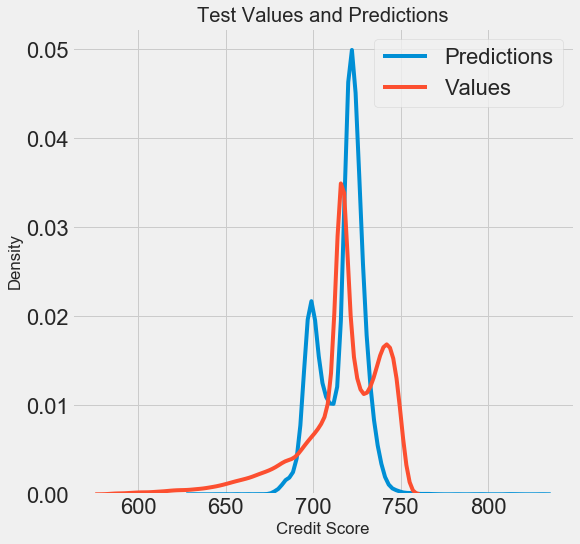

In [25]:
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)

print('Linear Regression Performance on the test set: MAE = %0.4f' % lr_mae)

C:\ProgramData\Anaconda3\envs\fastai_v1\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest Regression Performance on the test set: MAE = 12.8305


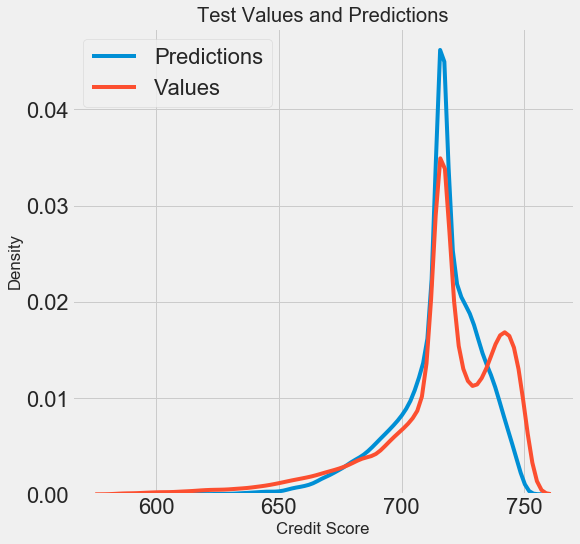

In [26]:
random_forest = RandomForestRegressor(random_state=60)
random_forest_mae = fit_and_evaluate(random_forest)

print('Random Forest Regression Performance on the test set: MAE = %0.4f' % random_forest_mae)

Gradient Boosted Regression Performance on the test set: MAE = 15.1527


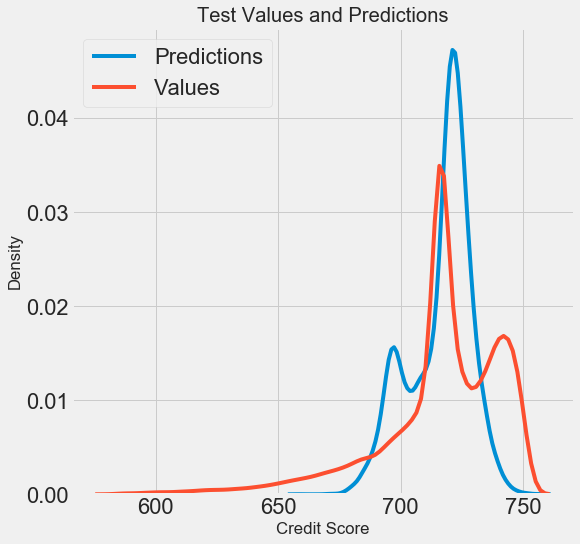

In [27]:
gradient_boosted = GradientBoostingRegressor(random_state=60)
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)

print('Gradient Boosted Regression Performance on the test set: MAE = %0.4f' % gradient_boosted_mae)

K-Nearest Neighbors Regression Performance on the test set: MAE = 16.9282


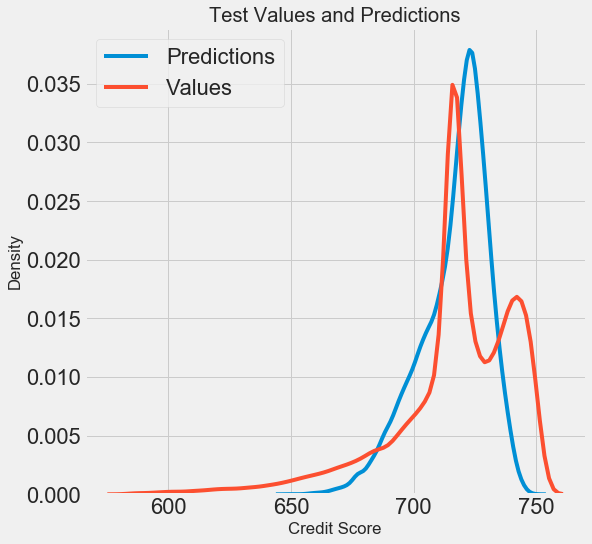

In [28]:
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae = fit_and_evaluate(knn)

print('K-Nearest Neighbors Regression Performance on the test set: MAE = %0.4f' % knn_mae)

In [29]:
xgb = XGBRegressor()
xgb_mae = fit_and_evaluate(xgb)

print('XGB Regression Performance on the test set: MAE = %0.4f' % xgb_mae)

NameError: name 'XGBRegressor' is not defined

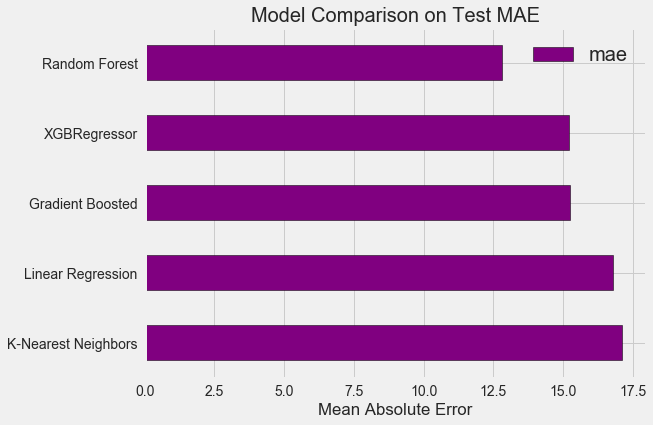

In [27]:
plt.style.use('fivethirtyeight')
figsize(8, 6)

# Dataframe to hold the results
model_comparison = pd.DataFrame({'model': ['Linear Regression',
                                           'Random Forest', 'XGBRegressor', 'Gradient Boosted',
                                            'K-Nearest Neighbors'],
                                 'mae': [lr_mae, random_forest_mae, xgb_mae,
                                         gradient_boosted_mae, knn_mae]})

# Horizontal bar chart of test mae
model_comparison.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                           color = 'purple', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Mean Absolute Error'); plt.xticks(size = 14)
plt.title('Model Comparison on Test MAE', size = 20);

In [31]:
X.to_csv('data/training_features_sc.csv', index = False)
X_test.to_csv('data/testing_features_sc.csv', index = False)


Although this is not a fair comparison because all the default parameters are used in making the models, but from the errors it can be inferred that the problem is Learnable, because all the models did significantly better than the baseline error of : 17.626


## Model Optimization¶

In machine learning, optimizing a model means finding the best set of hyperparameters for a particular problem.

Hyperparameters
First off, we need to understand what model hyperparameters are in contrast to model parameters :

- Model hyperparameters are best thought of as settings for a machine learning algorithm that are tuned by the data scientist before training. Examples would be the number of trees in the random forest, or the number of neighbors used in K Nearest Neighbors Regression.
- Model parameters are what the model learns during training, such as the weights in the linear regression.


### Hyperparameter Tuning with Random Search and Cross Validation

We can choose the best hyperparameters for a model through random search and cross validation.

- Random search refers to the method in which we choose hyperparameters to evaluate: we define a range of options, and then randomly select combinations to try. This is in contrast to grid search which evaluates every single combination we specify. Generally, random search is better when we have limited knowledge of the best model hyperparameters and we can use random search to narrow down the options and then use grid search with a more limited range of options.

- Cross validation is the method used to assess the performance of the hyperparameters. Rather than splitting the training set up into separate training and validation sets which reduces the amount of training data we can use, we use K-Fold Cross Validation. This means dividing the training data into K folds, and then going through an iterative process where we first train on K-1 of the folds and then evaluate performance on the kth fold. We repeat this process K times so eventually we will have tested on every example in the training data with the key that each iteration we are testing on data that we did not train on. At the end of K-fold cross validation, we take the average error on each of the K iterations as the final performance measure and then train the model on all the training data at once. The performance we record is then used to compare different combinations of hyperparameters.

A picture of k-fold cross validation using k = 5 is shown below:

![title](img/kfold_cv.png)


We selected 6 different hyperparameters to tune in the gradient boosting regressor. These all will affect the model in different ways that are hard to determine ahead of time, and the only method for finding the best combination for a specific problem is to test them out! To read about the hyperparameters, I suggest taking a look at the Scikit-Learn documentation. For now, just know that we are trying to find the best combination of hyperparameters and because there is no theory to tell us which will work best, we just have to evaluate them, like runnning an experiment!

In the code below, we create the Randomized Search Object passing in the following parameters:

- estimator: the model
- param_distributions: the distribution of parameters we defined
- cv the number of folds to use for k-fold cross validation
- n_iter: the number of different combinations to try
- scoring: which metric to use when evaluating candidates
- n_jobs: number of cores to run in parallel (-1 will use all available)
- verbose: how much information to display (1 displays a limited amount)
- return_train_score: return the training score for each cross-validation fold
- random_state: fixes the random number generator used so we get the same results every run

The Randomized Search Object is trained the same way as any other scikit-learn model. After training, we can compare all the different hyperparameter combinations and find the best performing one.

In [54]:
# Loss function to be optimized
loss = ['ls', 'lad', 'huber']

# Number of trees used in the boosting process
n_estimators = [100, 500, 900, 1100, 1500]

# Maximum depth of each tree
max_depth = [2, 3, 5, 10, 15]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# Minimum number of samples to split a node
min_samples_split = [2, 4, 6, 10]

# Maximum number of features to consider for making splits
max_features = ['auto', 'sqrt', 'log2', None]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'loss': loss,
                       'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

In [55]:
# Create the model to use for hyperparameter tuning
model = GradientBoostingRegressor(random_state = 42)

# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=4, n_iter=25, 
                               scoring = 'neg_mean_absolute_error',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state=42)

Using random search is a good method to narrow down the possible hyperparameters to try. Initially, we had no idea which combination would work the best, but this at least narrows down the range of options.

We could use the random search results to inform a grid search by creating a grid with hyperparameters close to those that worked best during the randomized search. However, rather than evaluating all of these settings again, I will focus on a single one, the number of trees in the forest (n_estimators). By varying only one hyperparameter, we can directly observe how it affects performance. In the case of the number of trees, we would expect to see a significant affect on the amount of under vs overfitting.

Here we will use grid search with a grid that only has the n_estimators hyperparameter. We will evaluate a range of trees then plot the training and testing performance to get an idea of what increasing the number of trees does for our model. We will fix the other hyperparameters at the best values returned from random search to isolate the number of trees effect.

In [56]:
# Fit on the training data
random_cv.fit(X, y)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 140.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 260.5min finished


RandomizedSearchCV(cv=4, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=25, n_jobs=-1,
          param_distributions={'loss': ['ls', 'lad', 'huber'], 'n_estimators': [100, 500, 900, 1100, 1500], 'max_depth': [2, 3, 5, 10, 15], 'min_samples_leaf': [1, 2, 4, 6, 8], 'min_samples_split': [2, 4, 6, 10], 'max_features': ['auto', 'sqrt', 'log2', None]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=1)

In [57]:
# Get all of the cv results and sort by the test performance
random_results = pd.DataFrame(random_cv.cv_results_).sort_values('mean_test_score', ascending = False)

random_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_loss,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
18,2579.520742,107.243201,1.175855,0.051035,500,6,1,auto,15,huber,"{'n_estimators': 500, 'min_samples_split': 6, ...",-12.476489,-12.562728,-12.504240,-12.349905,-12.473341,0.077767,1,-0.534887,-0.591478,-0.478012,-0.577275,-0.545413,0.044133
6,2447.932807,13.101611,4.093299,0.223862,1500,6,2,sqrt,15,huber,"{'n_estimators': 1500, 'min_samples_split': 6,...",-12.612549,-12.645109,-12.695003,-12.687102,-12.659941,0.033291,2,-0.175925,-0.168466,-0.183080,-0.180738,-0.177053,0.005588
10,2156.564860,4.298441,1.467573,0.101820,1100,10,6,None,10,huber,"{'n_estimators': 1100, 'min_samples_split': 10...",-12.818035,-12.927894,-12.748263,-12.738962,-12.808289,0.075514,3,-3.922662,-3.973404,-4.075779,-3.980915,-3.988190,0.055311
2,1183.418594,13.435640,0.727804,0.050053,500,4,2,auto,10,huber,"{'n_estimators': 500, 'min_samples_split': 4, ...",-12.997253,-13.004008,-12.853459,-12.895099,-12.937455,0.064912,4,-4.823607,-5.041550,-5.082293,-4.768038,-4.928872,0.135261
8,829.954206,4.075024,2.400328,0.063062,1500,6,2,sqrt,10,huber,"{'n_estimators': 1500, 'min_samples_split': 6,...",-12.973132,-12.953669,-13.023579,-12.925951,-12.969083,0.035652,5,-2.186969,-2.272098,-2.235860,-2.247594,-2.235630,0.030988
15,438.648895,1.391024,0.265042,0.024615,100,4,8,auto,15,ls,"{'n_estimators': 100, 'min_samples_split': 4, ...",-13.112512,-13.215446,-13.118021,-13.092073,-13.134513,0.047716,6,-5.766340,-5.773138,-5.778642,-5.851769,-5.792472,0.034511
4,608.271070,3.828564,1.623408,0.033043,900,6,6,sqrt,15,lad,"{'n_estimators': 900, 'min_samples_split': 6, ...",-13.171060,-13.168446,-13.148670,-13.137128,-13.156326,0.014064,7,-6.370676,-6.270156,-6.366043,-6.262568,-6.317361,0.051096
12,423.357558,10.644307,0.541801,0.014526,500,6,6,None,5,lad,"{'n_estimators': 500, 'min_samples_split': 6, ...",-13.208748,-13.318931,-13.190719,-13.183765,-13.225541,0.054684,8,-12.328783,-12.241618,-12.302704,-12.255932,-12.282259,0.035097
20,306.323180,6.573588,0.779912,0.005509,500,6,1,sqrt,10,huber,"{'n_estimators': 500, 'min_samples_split': 6, ...",-13.258396,-13.318293,-13.312760,-13.208668,-13.274529,0.044651,9,-5.846753,-5.792203,-5.905850,-5.949496,-5.873575,0.059470
19,507.257081,20.147966,1.003320,0.123217,1100,6,2,auto,3,lad,"{'n_estimators': 1100, 'min_samples_split': 6,...",-13.470883,-13.577957,-13.382680,-13.455216,-13.471684,0.069799,10,-13.210885,-13.168364,-13.108040,-13.211785,-13.174768,0.042333


In [58]:
random_cv.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=15,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=6,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             presort='auto', random_state=42, subsample=1.0, verbose=0,
             warm_start=False)

In [59]:

# Number of trees used in the boosting process
n_estimators = [100, 500, 900, 1100, 1500]

# Maximum depth of each tree
max_depth = [2, 3, 5, 10, 15]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# Minimum number of samples to split a node
min_samples_split = [2, 4, 6, 10]

# Maximum number of features to consider for making splits
max_features = ['auto', 'sqrt', 'log2', None]



# Define the grid of hyperparameters to search

hyperparameter_gridr = {
                       'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features,
                       'bootstrap':boot}

In [60]:
# Create the model to use for hyperparameter tuning
model_r = RandomForestRegressor(random_state = 42)

# Set up the random search with 4-fold cross validation
random_cv_r = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_gridr,
                               cv=4, n_iter=25, 
                               scoring = 'neg_mean_absolute_error',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state=42)

In [61]:
# Fit on the training data
random_cv_r.fit(X, y)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 121.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 424.1min finished


RandomizedSearchCV(cv=4, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=25, n_jobs=-1,
          param_distributions={'n_estimators': [100, 500, 900, 1100, 1500], 'max_depth': [2, 3, 5, 10, 15], 'min_samples_leaf': [1, 2, 4, 6, 8], 'min_samples_split': [2, 4, 6, 10], 'max_features': ['auto', 'sqrt', 'log2', None]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=1)

In [62]:
# Get all of the cv results and sort by the test performance
random_results_r = pd.DataFrame(random_cv_r.cv_results_).sort_values('mean_test_score', ascending = False)

random_results_r.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
21,5417.286299,56.989557,2.769092,0.044494,1500,2,6,auto,15,"{'n_estimators': 1500, 'min_samples_split': 2,...",-12.417139,-12.446750,-12.369216,-12.341556,-12.393665,0.040872,1,-0.087869,-0.079545,-0.072505,-0.085666,-0.081396,0.005971
24,4392.284687,50.024048,1.544120,0.284366,900,2,2,None,15,"{'n_estimators': 900, 'min_samples_split': 2, ...",-12.399706,-12.447777,-12.460213,-12.374670,-12.420591,0.034835,2,-0.050765,-0.068096,-0.058792,-0.044535,-0.055547,0.008834
18,2062.779283,17.960195,1.036478,0.086280,500,4,4,auto,15,"{'n_estimators': 500, 'min_samples_split': 4, ...",-12.456686,-12.571207,-12.499355,-12.377687,-12.476234,0.070086,3,-0.692740,-0.778037,-0.769630,-0.749410,-0.747454,0.033259
22,1706.002344,36.052721,0.993092,0.044488,500,2,8,None,15,"{'n_estimators': 500, 'min_samples_split': 2, ...",-12.672937,-12.745187,-12.673896,-12.602467,-12.673622,0.050461,4,-2.064204,-2.056770,-2.076962,-1.987371,-2.046327,0.034796
7,601.025207,4.720961,1.433416,0.031801,500,6,2,sqrt,15,"{'n_estimators': 500, 'min_samples_split': 6, ...",-12.736095,-12.800485,-12.785951,-12.757456,-12.769997,0.024953,5,-0.485892,-0.479682,-0.499527,-0.493873,-0.489744,0.007564
19,750.523972,2.640760,2.373900,0.185700,900,6,4,log2,15,"{'n_estimators': 900, 'min_samples_split': 6, ...",-12.870023,-12.870503,-12.855928,-12.861667,-12.864530,0.006084,6,-0.432422,-0.431269,-0.441891,-0.454724,-0.440077,0.009408
4,2776.584248,27.871743,1.982694,0.176418,1500,4,8,auto,10,"{'n_estimators': 1500, 'min_samples_split': 4,...",-12.882477,-12.986470,-12.894836,-12.860762,-12.906136,0.047958,7,-2.666311,-2.736885,-2.750622,-2.909716,-2.765883,0.088989
5,2111.650030,8.299171,1.555340,0.057725,1100,6,6,auto,10,"{'n_estimators': 1100, 'min_samples_split': 6,...",-12.922642,-12.971254,-12.873159,-12.933105,-12.925040,0.034993,8,-3.278768,-3.266619,-3.225424,-3.284750,-3.263890,0.023149
9,516.872110,2.838106,1.756801,0.060971,1100,2,2,sqrt,10,"{'n_estimators': 1100, 'min_samples_split': 2,...",-13.073782,-13.075319,-13.122132,-13.014434,-13.071417,0.038209,9,-2.563753,-2.525826,-2.509905,-2.563142,-2.540656,0.023477
11,1690.225301,9.578157,1.144937,0.055661,900,6,8,auto,10,"{'n_estimators': 900, 'min_samples_split': 6, ...",-13.081103,-13.172688,-13.090497,-13.017478,-13.090442,0.055171,10,-4.456700,-4.438544,-4.537760,-4.502136,-4.483785,0.038828


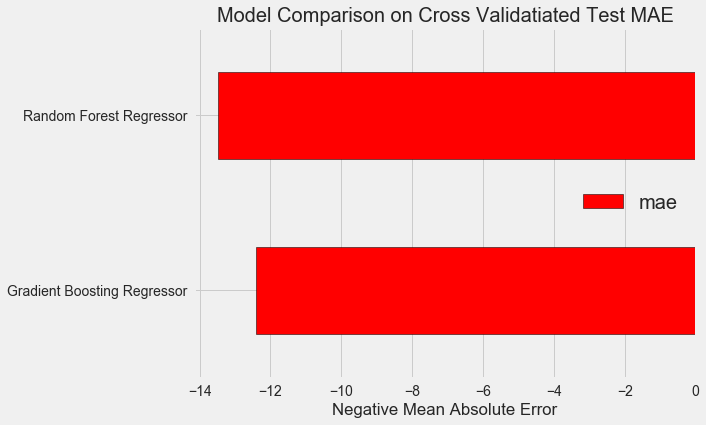

In [63]:
plt.style.use('fivethirtyeight')
figsize = (4,4)

# Dataframe to hold the results
model_comparison = pd.DataFrame({'model': ['Gradient Boosting Regressor',
                                           'Random Forest Regressor'],
                                 'mae': [-12.413966, -13.471712]})

# Horizontal bar chart of test mae
model_comparison.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                           color = 'red', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Negative Mean Absolute Error'); plt.xticks(size = 14)
plt.title('Model Comparison on Cross Validatiated Test MAE', size = 20);

In [ ]:
# Create a range of trees to evaluate
trees_grid = {'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]}

model = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=15,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=6,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             presort='auto', random_state=42, subsample=1.0, verbose=0,
             warm_start=False)

# Grid Search Object using the trees range and the random forest model
grid_search = GridSearchCV(estimator = model, param_grid=trees_grid, cv = 4, 
                           scoring = 'neg_mean_absolute_error', verbose = 1,
                           n_jobs = -1, return_train_score = True)

In [ ]:
# Fit the grid search
grid_search.fit(X, y)

In [ ]:
# Get the results into a dataframe
results = pd.DataFrame(grid_search.cv_results_)

# Plot the training and testing error vs number of trees
figsize(8, 8)
plt.style.use('fivethirtyeight')
plt.plot(results['param_n_estimators'], -1 * results['mean_test_score'], label = 'Testing Error')
plt.plot(results['param_n_estimators'], -1 * results['mean_train_score'], label = 'Training Error')
plt.xlabel('Number of Trees'); plt.ylabel('Mean Abosolute Error'); plt.legend();
plt.title('Performance vs Number of Trees');

In [ ]:
results.sort_values('mean_test_score', ascending = False).head(5)

In [50]:
# Default model
default_model = GradientBoostingRegressor(random_state = 42)

# Select the best model
final_model = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=15,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=6,
             min_weight_fraction_leaf=0.0, n_estimators=200,
             presort='auto', random_state=42, subsample=1.0, verbose=0,
             warm_start=False)
RF_model = RandomForestRegressor(max_features='auto', criterion='friedman_mse', max_depth=15,max_leaf_nodes=None, 
                                 min_samples_split=6, min_samples_leaf=1, n_estimators=200,n_jobs=-1, min_weight_fraction_leaf=0.0)


final_model

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=15,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=6,
             min_weight_fraction_leaf=0.0, n_estimators=200,
             presort='auto', random_state=42, subsample=1.0, verbose=0,
             warm_start=False)

In [51]:
%%timeit -n 1 -r 5
default_model.fit(X, y)

12.1 s ± 1.39 s per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [52]:
%%timeit -n 1 -r 5
RF_model.fit(X, y)

48.9 s ± 2.16 s per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [53]:
%%timeit -n 1 -r 5
final_model.fit(X, y)

11min 47s ± 35.1 s per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [54]:
default_pred = default_model.predict(X_test)
final_pred = final_model.predict(X_test)
rf_pred = RF_model.predict(X_test)
print('Default model performance on the test set:   MAE = %0.4f.' % mae(y_test, default_pred))
print('Final model performance on the test set:   MAE = %0.4f.' % mae(y_test, final_pred))
print('RF model performance on the test set:   MAE = %0.4f.' % mae(y_test, rf_pred))

Default model performance on the test set:   MAE = 15.2584.
Final model performance on the test set:   MAE = 11.8438.
RF model performance on the test set:   MAE = 13.2327.


In [65]:
ensemble_pred = (final_pred + rf_pred) /2
mae(y_test, ensemble_pred)

12.375234680132943

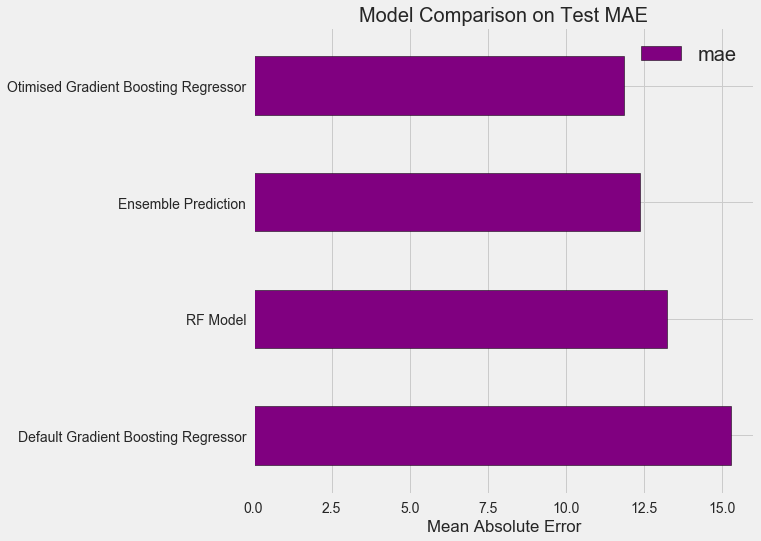

In [57]:
plt.style.use('fivethirtyeight')
figsize = (8,6)

# Dataframe to hold the results
model_comparison = pd.DataFrame({'model': ['Default Gradient Boosting Regressor',
                                           'Otimised Gradient Boosting Regressor', 
                                              'RF Model', 'Ensemble Prediction'],
                                 'mae': [mae(y_test, default_pred), mae(y_test, final_pred), mae(y_test, rf_pred),mae(y_test, ensemble_pred) ]})

# Horizontal bar chart of test mae
model_comparison.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                           color = 'purple', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Mean Absolute Error'); plt.xticks(size = 14)
plt.title('Model Comparison on Test MAE', size = 20);

C:\Users\User\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


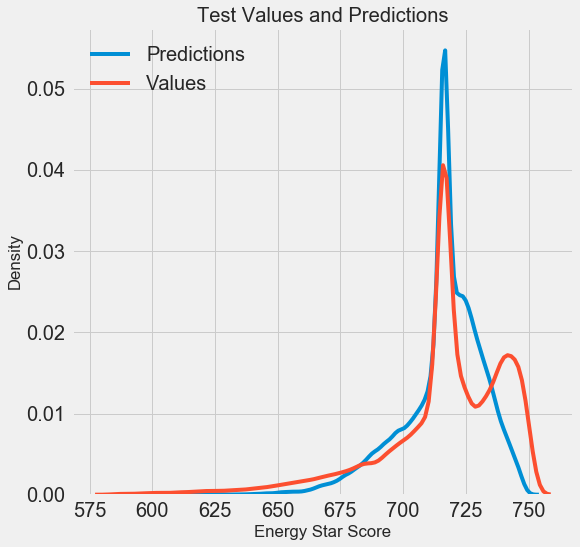

In [60]:
# Density plot of the final predictions and the test values
sns.kdeplot(ensemble_pred, label = 'Predictions')
sns.kdeplot(y_test, label = 'Values')

# Label the plot
plt.xlabel('Energy Star Score'); plt.ylabel('Density');
plt.title('Test Values and Predictions');

C:\Users\User\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


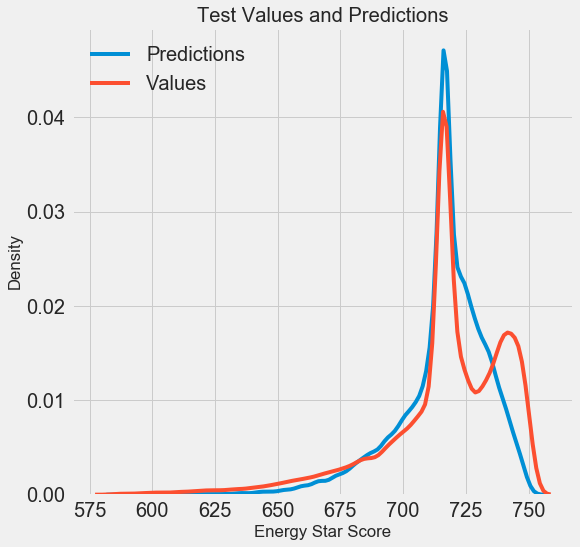

In [58]:
# Density plot of the final predictions and the test values
sns.kdeplot(final_pred, label = 'Predictions')
sns.kdeplot(y_test, label = 'Values')

# Label the plot
plt.xlabel('Energy Star Score'); plt.ylabel('Density');
plt.title('Test Values and Predictions');

The distribution looks to be nearly the same although the bimodal charterstics of the true distribution was not replicated in the predictions. It appears the model might be less accurate at predicting the values above 710, but that is not that important in our problem set, because predicting the lower values is the important part for predicting defaulters. Accuracy of Eligible candidate scores are not a requirement.

Another diagnostic plot is a histogram of the residuals. Ideally, we would hope that the residuals are normally distributed, meaning that the model is wrong the same amount in both directions (high and low).

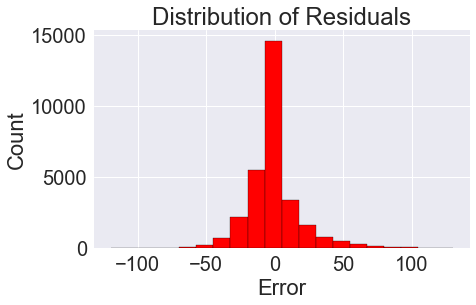

In [44]:
figsize = (6, 6)

# Calculate the residuals 
residuals = final_pred - y_test

# Plot the residuals in a histogram
plt.hist(residuals, color = 'red', bins = 20,
         edgecolor = 'black')
plt.xlabel('Error'); plt.ylabel('Count')
plt.title('Distribution of Residuals');

The residuals are close to normally disributed. These indicate errors where the model estimate was far below that of the true value.

In [108]:
cols = train_features.columns
cols

Index(['CurrentLoanAmount', 'Annual Income', 'Monthly Debt',
       'Years of Credit History', 'Number of Open Accounts',
       'Number of Credit Problems', 'Current Credit Balance',
       'Maximum Open Credit', 'Tax Liens', 'LoanStatus_Charged Off',
       'LoanStatus_Fully Paid', 'Term_Long Term', 'Term_Short Term',
       'Years in current job_1 year', 'Years in current job_10+ years',
       'Years in current job_2 years', 'Years in current job_3 years',
       'Years in current job_4 years', 'Years in current job_5 years',
       'Years in current job_6 years', 'Years in current job_7 years',
       'Years in current job_8 years', 'Years in current job_9 years',
       'Years in current job_< 1 year', 'Home Ownership_HaveMortgage',
       'Home Ownership_Home Mortgage', 'Home Ownership_Own Home',
       'Purpose_Business Loan', 'Purpose_Buy House', 'Purpose_Buy a Car',
       'Purpose_Debt Consolidation', 'Purpose_Educational Expenses',
       'Purpose_Home Improvements', 'Purpo

In [109]:
imp = RF_model.feature_importances_

In [110]:
fi = pd.DataFrame({'name' : cols,
                   'values': imp})

Text(0.5,1,'Feature Importances of using Random Forest')

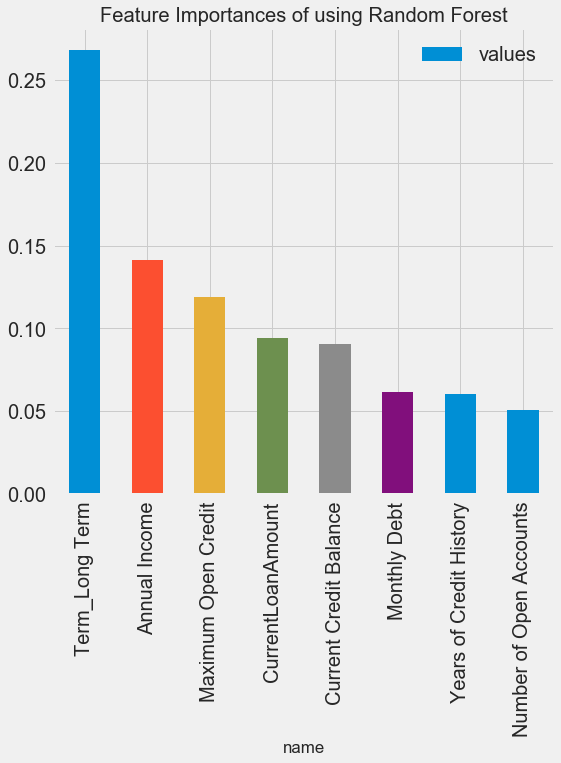

In [121]:
fi.sort_values('values', ascending=False)[:8].plot(x='name', y='values', kind = 'bar')
plt.title('Feature Importances of using Random Forest')

In [122]:
gimp = final_model.feature_importances_

In [123]:
g_fi = pd.DataFrame({'name':cols, 'values': gimp})

Text(0.5,1,'Feature Importances of using Optimised Gradient Boosted Regression')

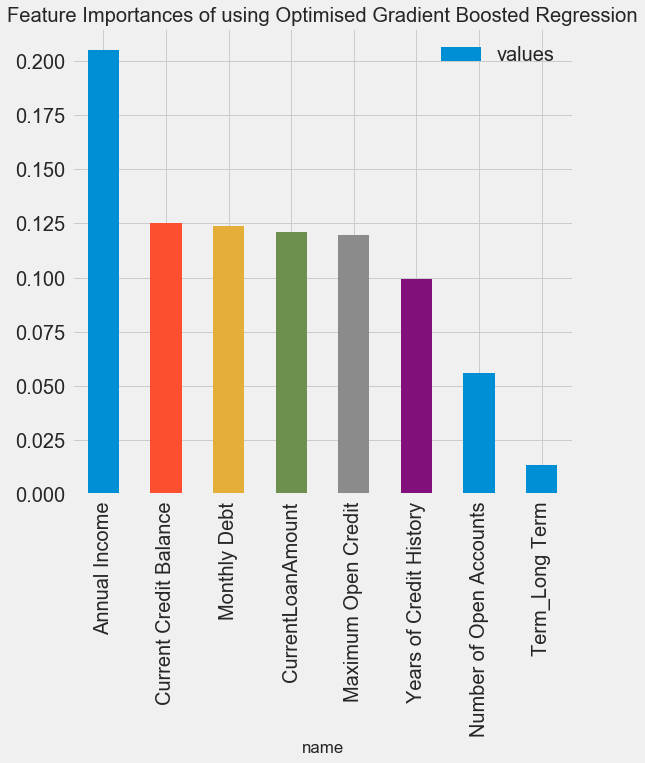

In [124]:
g_fi.sort_values('values', ascending=False)[:8].plot(x='name', y='values', kind = 'bar')
plt.title('Feature Importances of using Optimised Gradient Boosted Regression')

In [127]:
%time preds = np.stack([t.predict(X_test) for t in RF_model.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

Wall time: 2.16 s


(732.2639183713083, 4.4063553359430285)

## By keeping the top 9 features from feature importances. Rebuild both the models
#### To check if any increase in performance occurs

In [166]:
cols_tokeep = g_fi.sort_values('values', ascending=False)['name'][:25]

In [168]:
np.array(cols_tokeep)

array(['Annual Income', 'Current Credit Balance', 'Monthly Debt',
       'CurrentLoanAmount', 'Maximum Open Credit',
       'Years of Credit History', 'Number of Open Accounts',
       'Term_Long Term', 'Term_Short Term',
       'Years in current job_3 years', 'Home Ownership_Home Mortgage',
       'Years in current job_< 1 year', 'Years in current job_10+ years',
       'Years in current job_5 years', 'Years in current job_2 years',
       'Years in current job_4 years', 'Number of Credit Problems',
       'Years in current job_1 year', 'Years in current job_7 years',
       'Years in current job_9 years', 'Purpose_Debt Consolidation',
       'Home Ownership_Own Home', 'Years in current job_6 years',
       'LoanStatus_Fully Paid', 'Years in current job_8 years'],
      dtype=object)

In [169]:
train_lessFeatures = train_features[cols_tokeep]
test_lessFeatures = test_features[cols_tokeep]

In [170]:

# Create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on the training data
scaler.fit(train_lessFeatures)

# Transform both the training and testing data
X_lf = scaler.transform(train_lessFeatures)
X_test_lf = scaler.transform(test_lessFeatures)

In [171]:
# Select the best model
final_model_lf = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=15,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=6,
             min_weight_fraction_leaf=0.0, n_estimators=200,
             presort='auto', random_state=42, subsample=1.0, verbose=0,
             warm_start=False)
RF_model_lf = RandomForestRegressor(max_features='auto', criterion='friedman_mse', max_depth=15,max_leaf_nodes=None, 
                                 min_samples_split=6, min_samples_leaf=1, n_estimators=200,n_jobs=-1, min_weight_fraction_leaf=0.0)


In [172]:
%timeit RF_model_lf.fit(X_lf, y)

36.8 s ± 1.01 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [173]:
rf_pred_lf = RF_model_lf.predict(X_test_lf)

In [174]:
rf_pred = RF_model.predict(X_test)
print('Default model performance on the test set:   MAE = %0.4f.' % mae(y_test, default_pred))

Default model performance on the test set:   MAE = 15.2584.


In [175]:
%timeit final_model_lf.fit(X_lf, y)

10min 35s ± 20 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [176]:
gbm_pred_lf = final_model_lf.predict(X_test_lf)

In [177]:
print('Default model performance on the test set:   MAE = %0.4f.' % mae(y_test, gbm_pred_lf))

Default model performance on the test set:   MAE = 11.9354.


C:\Users\User\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


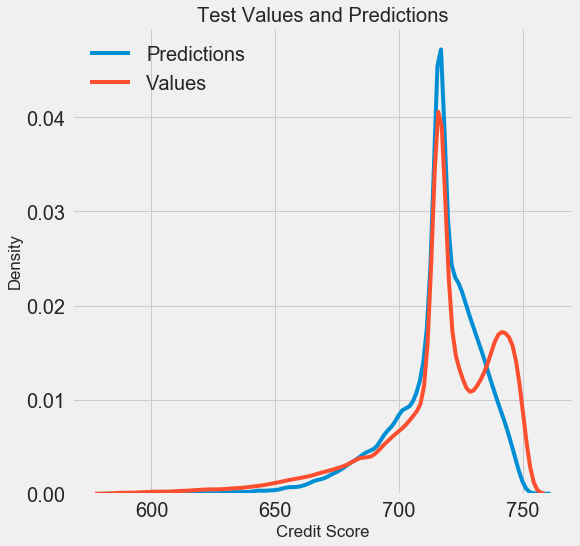

In [178]:
# Density plot of the final predictions and the test values
sns.kdeplot(gbm_pred_lf, label = 'Predictions')
sns.kdeplot(y_test, label = 'Values')

# Label the plot
plt.xlabel('Credit Score'); plt.ylabel('Density');
plt.title('Test Values and Predictions');

## Try to build two models to suit different interpretations.
### One will be give a binary prediction. The other will give the confidence score of the the prediction

#### More robust and generalized interpretation

In [201]:
idxs = train_labels.replace(to_replace=(train_labels['score']< 700), value=0)

In [285]:
binary = train_labels.mask(train_labels['score'] < 700)
binary = binary.fillna(value=0)

In [286]:
binary = binary.mask(binary['score'] >= 700)
binary = binary.fillna(value=1.0)

In [291]:
train_bin = np.array(binary['score'])

In [292]:
binaryt = test_labels.mask(test_labels['score'] < 700)
binaryt = binaryt.fillna(value=0)
binaryt = binaryt.mask(binaryt['score'] >= 700)
binaryt = binaryt.fillna(value=1.0)

In [293]:
test_bin = np.array(binaryt['score'])
print(len(train_bin), len(test_bin)) 
train_bin

69496 29784


array([1., 1., 1., ..., 1., 1., 1.])

## Train RF Model to give binary outputs

In [307]:
RF_model_bin = RandomForestRegressor(max_features='auto', max_depth=30,max_leaf_nodes=None, 
                                 min_samples_split=6, min_samples_leaf=1, n_estimators=500,n_jobs=-1, verbose=1)

In [308]:
RF_model_bin.fit(X_lf, train_bin)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.8min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=6,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

In [309]:
bin_preds = RF_model_bin.predict(X_test_lf)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.9s finished


In [310]:
print('Default model performance on the test set:   MAE = %0.4f.' % mae(test_bin, bin_preds))

Default model performance on the test set:   MAE = 0.1860.


In [314]:
for i in range(len(bin_preds)):
    if(bin_preds[i] > 0.5):
        bin_preds[i] = 1
    else:
        bin_preds[i] = 0

In [320]:
print('Default model performance on the test set:   MAE = %0.4f.' % mae(test_bin, bin_preds))

Default model performance on the test set:   MAE = 0.1110.


In [323]:
sum = 0
for i in range(len(test_bin)):
    if(test_bin[i] != bin_preds[i]):
        sum+=1

In [327]:
len(test_bin)

29784